# Тема 6.5. Обработка данных, полученных при выполнении полетных заданий в среде имитации полетов

## Повторение кода прошлого семинара, чтобы получить полетные данные для анализа

In [1]:
import logging
import sys

# logging.Logger - начальник.
# logging.Handler - курьер.
# logging.Formatter - стилист.
# logging.Filter - фильтр.

# Создадим сам логгер
logger = logging.getLogger("DroneController")
logger.setLevel(logging.DEBUG)

# Добавим обработчик для вывода в консоль
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)

# Добавим обработчик для вывода в файл
file_handler = logging.FileHandler("flight_data.csv", mode="w")
file_handler.setLevel(logging.DEBUG)

logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Создадим форматтеры для красоты вывода
console_formatter = logging.Formatter(
    "%(asctime)s :: %(levelname)s :: %(message)s"
)
file_formatter = logging.Formatter("%(message)s")

console_handler.setFormatter(console_formatter)
file_handler.setFormatter(file_formatter)


# Базовый фильтр ничего не умеет, поэтому создадим класс-наследник, который будет оставлять только записи нужного нам уровня
class SingleLevelFilter(logging.Filter):
    def __init__(self, level):
        self.level = level

    def filter(self, record):
        return record.levelno == self.level


file_filter = SingleLevelFilter(logging.DEBUG)
file_handler.addFilter(file_filter)

# Файл предполагается csv - закинем в него шапку
logger.debug("timestamp,x,y,z,vx,vy,vz")
# Проверим также работоспособность вывода в консоль
logger.info("OK")

2025-12-11 19:49:43,766 :: INFO :: OK


Наконец создадим файл логов, запустив простенькую полетную миссию

In [2]:
import time

import numpy as np
from control import ROSInterface

drone = ROSInterface(logger=logger)
time.sleep(2)
drone.takeoff(5.0)
drone.fly_to_pose(np.array([20.0, 15.0, 10.0]))
drone.fly_to_pose(np.array([0.0, 0.0, 5.0]))
drone.shutdown()

2025-12-11 19:49:44,177 :: INFO :: ROS 2 node initialized.
2025-12-11 19:49:44,208 :: INFO :: ROS 2 spin thread started.
2025-12-11 19:49:46,211 :: INFO :: Takeoff to altitude 5.0
2025-12-11 19:49:55,718 :: INFO :: Flying to pose [20. 15. 10.]
2025-12-11 19:50:23,144 :: INFO :: Flying to pose [0. 0. 5.]
2025-12-11 19:50:50,572 :: INFO :: Shutting down Drone Controller...
2025-12-11 19:50:50,572 :: INFO :: Waiting for spin thread to finish...
2025-12-11 19:50:50,574 :: INFO :: ROS 2 spin thread stopped.
2025-12-11 19:50:50,574 :: INFO :: Destroying node drone_controller...
2025-12-11 19:50:50,576 :: INFO :: Node destroyed.
2025-12-11 19:50:50,576 :: INFO :: Shutting down rclpy...
2025-12-11 19:50:50,576 :: INFO :: rclpy shut down.
2025-12-11 19:50:50,576 :: INFO :: Drone Controller shutdown complete.


## Визуализация и анализ данных

Как принято, начнем с импортов

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Получим датафрейм из файла логов

In [4]:
df = pd.read_csv("flight_data.csv")
df.head()

,timestamp,x,y,z,vx,vy,vz
0,1.765465e+09,1.134108e-11,-1.058161e-18,0.562008,1.647188e-12,2.488279e-19,0.001000
1,1.765465e+09,1.139631e-11,-1.044474e-18,0.562039,1.898450e-12,5.977988e-19,0.001000
2,1.765465e+09,-9.617890e-12,-2.925076e-16,0.562102,-1.933732e-09,-3.074502e-14,0.004090
3,1.765465e+09,5.479093e-09,9.061117e-14,0.562980,2.502260e-07,4.236948e-12,0.034113
4,1.765465e+09,3.266808e-08,9.105526e-13,0.564500,1.023560e-06,3.040213e-11,0.058844


Посмотрим на информацию о таблице и столбцах

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1374 non-null   float64
 1   x          1374 non-null   float64
 2   y          1374 non-null   float64
 3   z          1374 non-null   float64
 4   vx         1374 non-null   float64
 5   vy         1374 non-null   float64
 6   vz         1374 non-null   float64
dtypes: float64(7)
memory usage: 75.3 KB


Для начальных выводов полезно вывести некоторые описательные статистики

In [6]:
df.describe()

,timestamp,x,y,z,vx,vy,vz
count,1.374000e+03,1.374000e+03,1.374000e+03,1374.000000,1374.000000,1374.000000,1374.000000
mean,1.765465e+09,7.961199e+00,5.968375e+00,6.509263,-0.028739,0.050391,0.118440
std,1.919912e+01,8.237830e+00,6.194800e+00,2.750814,1.186258,0.563963,0.364823
min,1.765465e+09,-9.617890e-12,-2.925076e-16,0.562008,-3.995158,-1.702373,-0.820803
25%,1.765465e+09,1.396600e-01,9.896745e-02,5.021133,-0.153295,-0.049572,-0.020518
50%,1.765465e+09,3.801553e+00,2.790502e+00,5.820458,0.000177,0.000001,0.012944
75%,1.765465e+09,1.781028e+01,1.340448e+01,9.550862,0.137702,0.072854,0.441437
max,1.765465e+09,1.992334e+01,1.494573e+01,9.990855,3.600011,2.170374,2.108663


Сдвинем временные метки

In [7]:
df["timestamp"] -= df.loc[0]["timestamp"]
df.head()

,timestamp,x,y,z,vx,vy,vz
0,0.000000,1.134108e-11,-1.058161e-18,0.562008,1.647188e-12,2.488279e-19,0.001000
1,0.033525,1.139631e-11,-1.044474e-18,0.562039,1.898450e-12,5.977988e-19,0.001000
2,0.067081,-9.617890e-12,-2.925076e-16,0.562102,-1.933732e-09,-3.074502e-14,0.004090
3,0.100601,5.479093e-09,9.061117e-14,0.562980,2.502260e-07,4.236948e-12,0.034113
4,0.134130,3.266808e-08,9.105526e-13,0.564500,1.023560e-06,3.040213e-11,0.058844


и посмотрим, сколько занял весь полет

In [8]:
df["timestamp"].max()

np.float64(64.25995802879333)

Посмотрим на траекторию в 3D

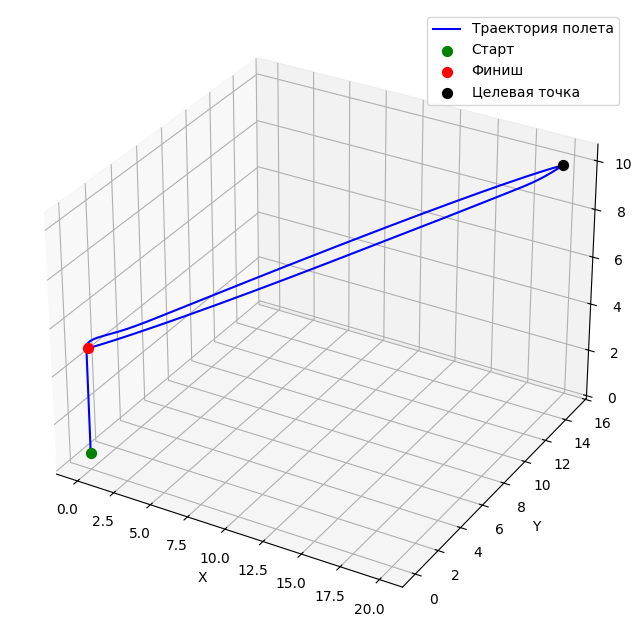

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Строим траекторию
ax.plot(df["x"], df["y"], df["z"], color="b", label="Траектория полета")

# Обозначим старт, финиш и целевую точку
ax.scatter(
    df["x"].iloc[0],
    df["y"].iloc[0],
    df["z"].iloc[0],
    color="g",
    s=50,
    label="Старт",
)
ax.scatter(
    df["x"].iloc[-1],
    df["y"].iloc[-1],
    df["z"].iloc[-1],
    color="r",
    s=50,
    label="Финиш",
)
# [20.0, 15.0, 10.0]
ax.scatter([20], [15], [10], color="black", s=50, label="Целевая точка")

# Подпишем оси
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Добавим легенду
ax.legend()

# Выведем график
plt.show()

Построим график изменения модуля скорости во времени

Но перед этим добавим нужный нам столбец в таблицу и заодно посмотрим его статистики

In [10]:
df["v"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2 + df["vz"] ** 2)
df["v"].describe()

count    1374.000000
mean        0.836175
std         1.084466
min         0.001000
25%         0.115257
50%         0.494073
75%         0.946059
max         4.379959
Name: v, dtype: float64

Построение графика в целом аналогично прошлому

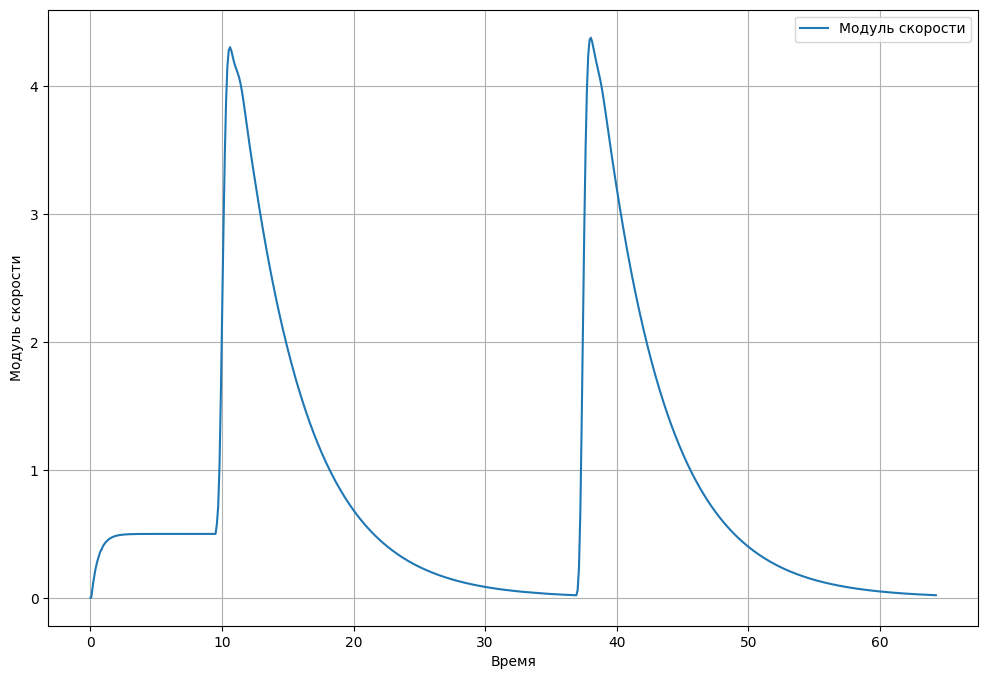

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(df["timestamp"], df["v"], label="Модуль скорости")
plt.xlabel("Время")
plt.ylabel("Модуль скорости")
plt.legend()
plt.grid(True)
plt.show()

Теперь давайте добавим в значения скорости шум и еще раз посмотрим на график

In [12]:
noise = np.random.normal(0, 0.5, size=len(df))

# Естественно к каждой составляющей можно добавлять свой шум, но для демонстрации ограничимся одним и тем же
df["v_noise"] = np.sqrt(
    (df["vx"] + noise) ** 2 + (df["vy"] + noise) ** 2 + (noise + df["vz"]) ** 2
)

In [13]:
df["v_noise"].head()

0    0.667780
1    1.465791
2    1.443155
3    0.131683
4    1.364990
Name: v_noise, dtype: float64

In [14]:
df["v_noise"].describe()

count    1374.000000
mean        1.217373
std         1.033666
min         0.019810
25%         0.496804
50%         0.902834
75%         1.571676
max         5.892809
Name: v_noise, dtype: float64

На график добавим обе скорости: с шумом и без

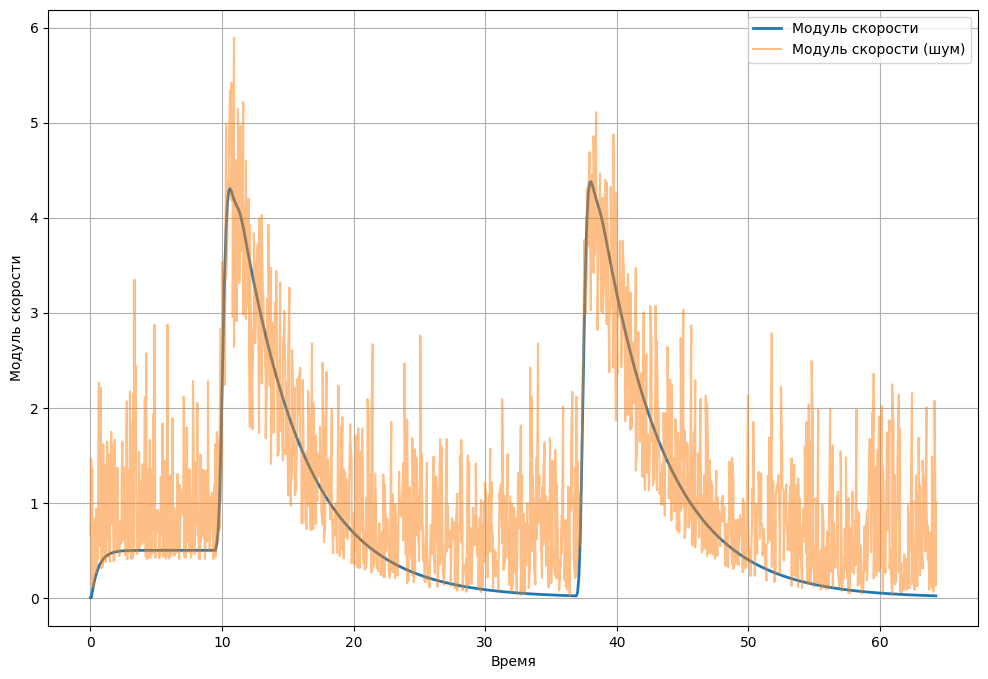

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(df["timestamp"], df["v"], label="Модуль скорости", linewidth=2)
plt.plot(
    df["timestamp"], df["v_noise"], label="Модуль скорости (шум)", alpha=0.5
)
plt.xlabel("Время")
plt.ylabel("Модуль скорости")
plt.legend()
plt.grid(True)
plt.show()

Рассмотрим простейшую фильтрацию - метод скользящей средней

In [16]:
window_size = 35
df["v_filtered"] = df["v_noise"].rolling(window=window_size, center=True).mean()

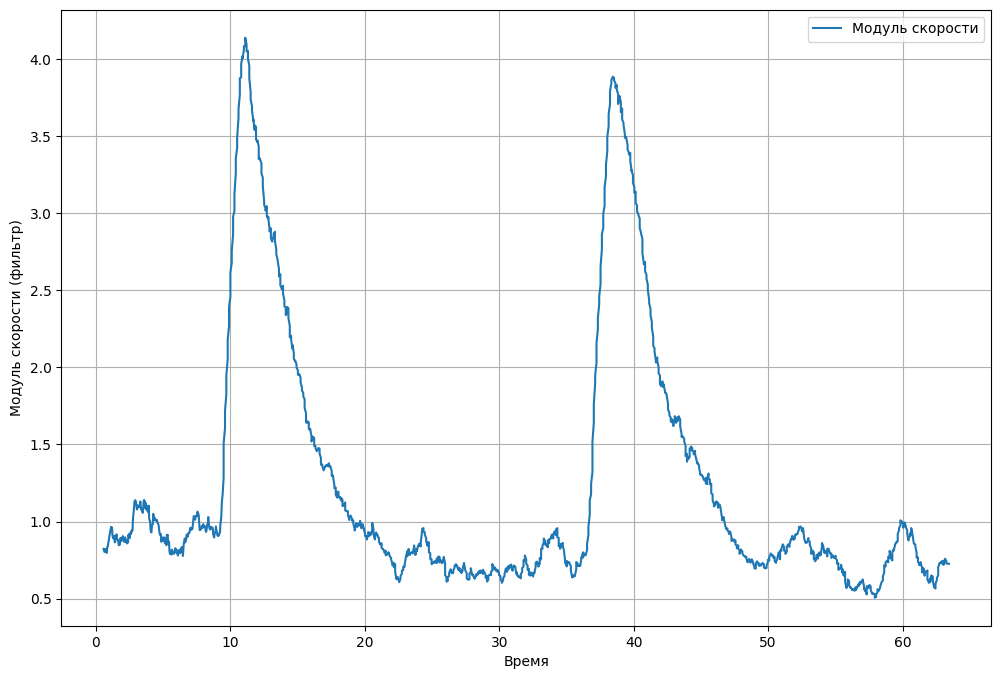

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(df["timestamp"], df["v_filtered"], label="Модуль скорости")
plt.xlabel("Время")
plt.ylabel("Модуль скорости (фильтр)")
plt.legend()
plt.grid(True)
plt.show()

Из рассмотренного выше графика траектории довольно сложно сразу понять высоту аппарата, поэтому давайте добавим карту цвета

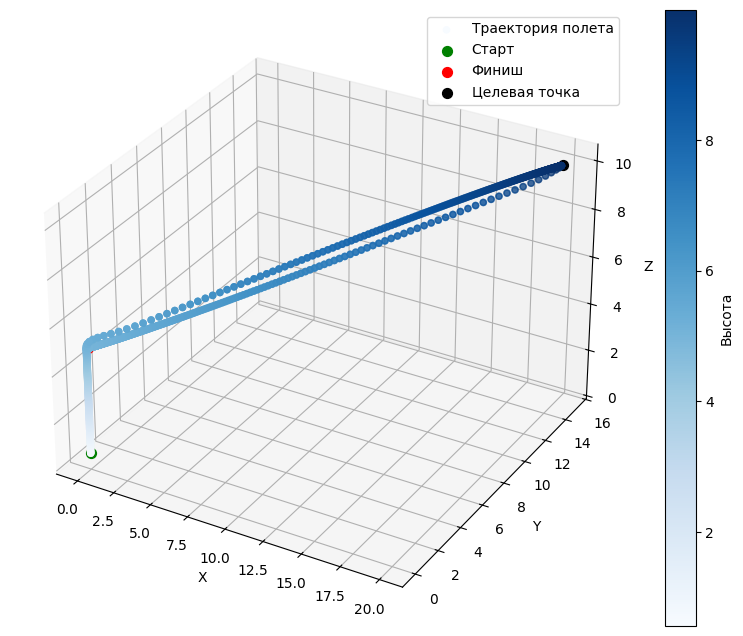

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    df["x"],
    df["y"],
    df["z"],
    label="Траектория полета",
    cmap="Blues",
    c=df["z"],
)

ax.scatter(
    df["x"].iloc[0],
    df["y"].iloc[0],
    df["z"].iloc[0],
    color="g",
    s=50,
    label="Старт",
)
ax.scatter(
    df["x"].iloc[-1],
    df["y"].iloc[-1],
    df["z"].iloc[-1],
    color="r",
    s=50,
    label="Финиш",
)
# [20.0, 15.0, 10.0]
ax.scatter([20], [15], [10], color="black", s=50, label="Целевая точка")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.colorbar(scatter, ax=ax, label="Высота")

ax.legend()
plt.show()

Из интересного осталось только посчитать длину траектории. Сделаем это, приблизив ее ломаной

In [19]:
x = np.array(df["x"])
y = np.array(df["y"])
z = np.array(df["z"])

l = len(df)
dist = 0.0

for i in range(l - 1):
    dist += np.sqrt(
        (x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2 + (z[i] - z[i + 1]) ** 2
    )

print(dist)

55.30112998431865
